In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 bird truck  deer  bird


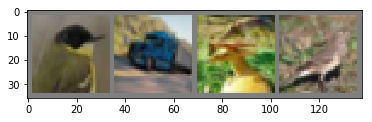

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 18, 5) 
        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(18, 16, 5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
net = net.to(device)   

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
for epoch in range(4):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.120
[1,  4000] loss: 1.757
[1,  6000] loss: 1.590
[1,  8000] loss: 1.516
[1, 10000] loss: 1.443
[1, 12000] loss: 1.408
[2,  2000] loss: 1.345
[2,  4000] loss: 1.297
[2,  6000] loss: 1.274
[2,  8000] loss: 1.214
[2, 10000] loss: 1.230
[2, 12000] loss: 1.201
[3,  2000] loss: 1.147
[3,  4000] loss: 1.096
[3,  6000] loss: 1.103
[3,  8000] loss: 1.073
[3, 10000] loss: 1.082
[3, 12000] loss: 1.080
[4,  2000] loss: 1.005
[4,  4000] loss: 0.998
[4,  6000] loss: 0.981
[4,  8000] loss: 0.988
[4, 10000] loss: 0.980
[4, 12000] loss: 0.990
Finished Training


GroundTruth:    cat  ship  ship plane


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9ffade9f98>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as co

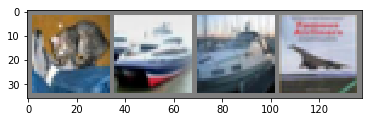

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [33]:
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship truck plane


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        #print(c)
print('Accuracy of the network on %d test images: %d %%' % (total, 100*correct/total))

Accuracy of the network on 10000 test images: 64 %


In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 66 %
Accuracy of  bird : 56 %
Accuracy of   cat : 48 %
Accuracy of  deer : 64 %
Accuracy of   dog : 44 %
Accuracy of  frog : 73 %
Accuracy of horse : 72 %
Accuracy of  ship : 78 %
Accuracy of truck : 78 %


In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _,predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] +=1
            
for i in range(10):
    print('Train set accuracy of %5s: %.2f %%' % (classes[i], 100*class_correct[i]/class_total[i]))

Train set accuracy of plane: 70.52 %
Train set accuracy of   car: 70.50 %
Train set accuracy of  bird: 64.26 %
Train set accuracy of   cat: 52.94 %
Train set accuracy of  deer: 70.74 %
Train set accuracy of   dog: 45.58 %
Train set accuracy of  frog: 75.34 %
Train set accuracy of horse: 76.92 %
Train set accuracy of  ship: 82.56 %
Train set accuracy of truck: 82.20 %


In [ ]:
outputSize(16, 2, 2, 0)

In [ ]:
A = np.random.randn(4,3)
B = np.sum(A, axis = 1, keepdims = True)

In [ ]:
B

In [ ]:
B.shape